In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (mean_absolute_error,r2_score,recall_score,f1_score,accuracy_score,precision_score,confusion_matrix,classification_report)
import joblib

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
#Load Dataset
file_path = '/content/drive/MyDrive/css_features_all_small.csv'
df = pd.read_csv(file_path)

In [4]:
#Clean + Preprocess
columns_to_drop = ['Unnamed: 0', 'file_number']
df_cleaned = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
df_cleaned.dropna(inplace=True)

In [5]:
# Identify Code Smells
smell_thresholds = df_cleaned.mean() + df_cleaned.std()
df_smells = df_cleaned > smell_thresholds
df_cleaned['Total_Code_Smells'] = df_smells.sum(axis=1)
df_cleaned['Code_Smell_Types'] = df_smells.apply(lambda row: list(row[row].index), axis=1)

In [6]:
#Normalize Features
feature_columns = [col for col in df_cleaned.columns if col not in ['Total_Code_Smells', 'Code_Smell_Types']]
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df_cleaned[feature_columns]), columns=feature_columns)

In [7]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df_cleaned['cluster'] = kmeans.fit_predict(X_scaled)
X_scaled['cluster'] = df_cleaned['cluster']

In [12]:
#Map Clusters → Severity Labels
cluster_avg = df_cleaned.groupby('cluster')['Total_Code_Smells'].mean().sort_values()
cluster_map = {
    cluster_avg.index[0]: 'Clean',
    cluster_avg.index[1]: 'Low',
    cluster_avg.index[2]: 'Medium',
    cluster_avg.index[3]: 'High'
}
df_cleaned['smell_severity_label'] = df_cleaned['cluster'].map(cluster_map)


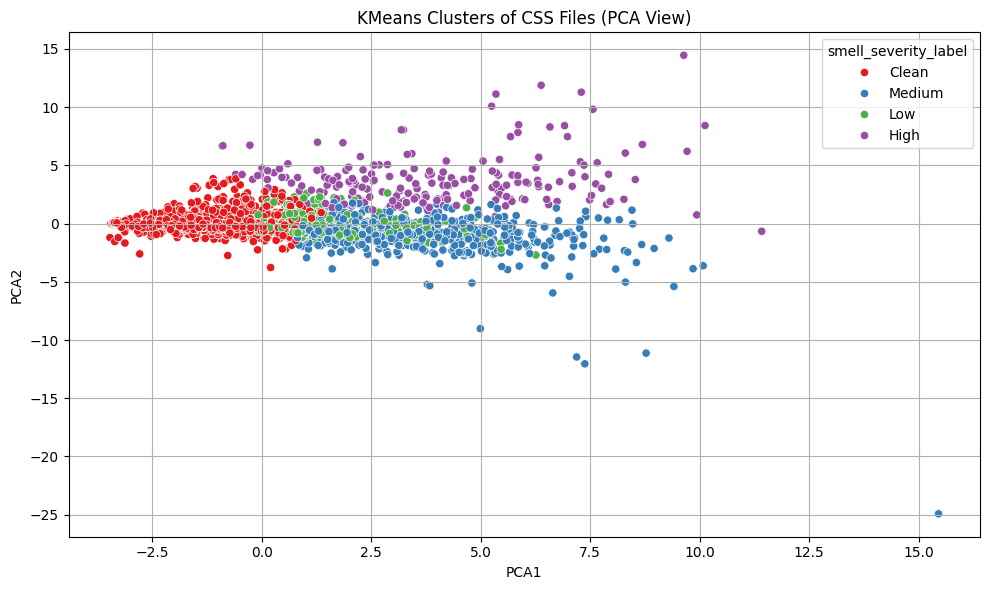

In [13]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled.drop(columns=['cluster']))
df_cleaned['PCA1'], df_cleaned['PCA2'] = pca_result[:, 0], pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_cleaned, x='PCA1', y='PCA2', hue='smell_severity_label', palette='Set1')
plt.title("KMeans Clusters of CSS Files (PCA View)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
#Train Random Forest Regressor

X = X_scaled.drop(columns=['cluster'])  # 👈 removes that extra column
y = df_cleaned['Total_Code_Smells']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = RandomForestRegressor(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = np.nan_to_num(clf.predict(X_test))


🔍 Regression Metrics:
MAE: 0.2922
R2 Score: 0.9593
Explained Variance: 95.93%

🔍 Classification Metrics (Binary):
Accuracy: 89.63%
Precision: 0.8490
Recall: 1.0000
F1 Score: 0.9183


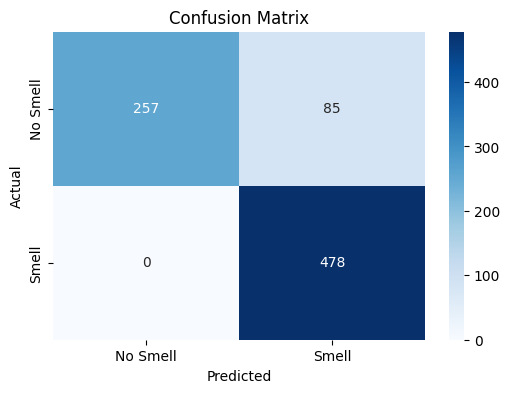


📋 Classification Report:
              precision    recall  f1-score   support

    No Smell       1.00      0.75      0.86       342
       Smell       0.85      1.00      0.92       478

    accuracy                           0.90       820
   macro avg       0.92      0.88      0.89       820
weighted avg       0.91      0.90      0.89       820


🔍 Severity Classification Metrics:
Accuracy: 100.00%

📋 Severity Classification Report:
              precision    recall  f1-score   support

       Clean       1.00      1.00      1.00       508
         Low       1.00      1.00      1.00       105
      Medium       1.00      1.00      1.00       164
        High       1.00      1.00      1.00        43

    accuracy                           1.00       820
   macro avg       1.00      1.00      1.00       820
weighted avg       1.00      1.00      1.00       820



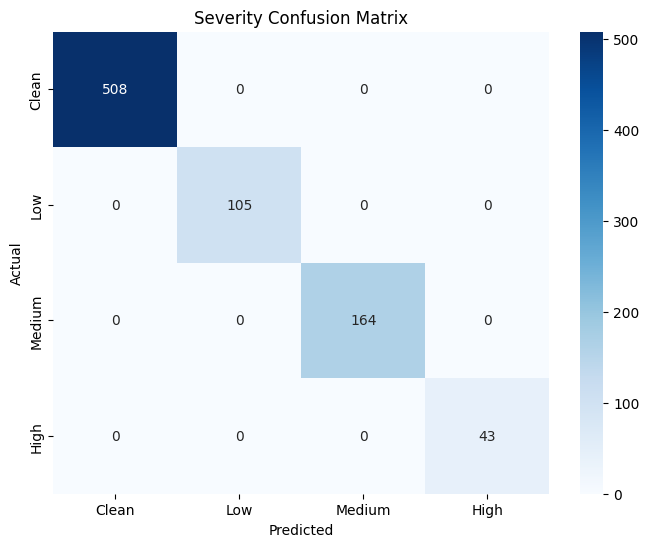

In [21]:
#Evaluate Model

y_pred_binary = np.where(y_pred > 0, 1, 0)
y_test_binary = np.where(y_test > 0, 1, 0)

# Regression Metrics
print("\n🔍 Regression Metrics:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"Explained Variance: {r2_score(y_test, y_pred)*100:.2f}%")

# Classification Metrics (binary)
print("\n🔍 Classification Metrics (Binary):")
print(f"Accuracy: {accuracy_score(y_test_binary, y_pred_binary)*100:.2f}%")
print(f"Precision: {precision_score(y_test_binary, y_pred_binary):.4f}")
print(f"Recall: {recall_score(y_test_binary, y_pred_binary):.4f}")
print(f"F1 Score: {f1_score(y_test_binary, y_pred_binary):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Smell', 'Smell'],
            yticklabels=['No Smell', 'Smell'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test_binary, y_pred_binary,
                           target_names=['No Smell', 'Smell']))

# Multi-class Classification Metrics (for severity levels)
if 'smell_severity_label' in df_cleaned:
    # Map labels to numerical values
    severity_map = {'Clean': 0, 'Low': 1, 'Medium': 2, 'High': 3}
    y_test_severity = df_cleaned.loc[y_test.index, 'smell_severity_label'].map(severity_map)

    # Predict severity (using cluster mapping)
    y_pred_severity = df_cleaned.loc[y_test.index, 'cluster'].map(cluster_map).map(severity_map)

    print("\n🔍 Severity Classification Metrics:")
    print(f"Accuracy: {accuracy_score(y_test_severity, y_pred_severity)*100:.2f}%")
    print("\n📋 Severity Classification Report:")
    print(classification_report(y_test_severity, y_pred_severity,
                              target_names=['Clean', 'Low', 'Medium', 'High']))

    # Confusion Matrix for severity
    cm_severity = confusion_matrix(y_test_severity, y_pred_severity)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_severity, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Clean', 'Low', 'Medium', 'High'],
                yticklabels=['Clean', 'Low', 'Medium', 'High'])
    plt.title('Severity Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

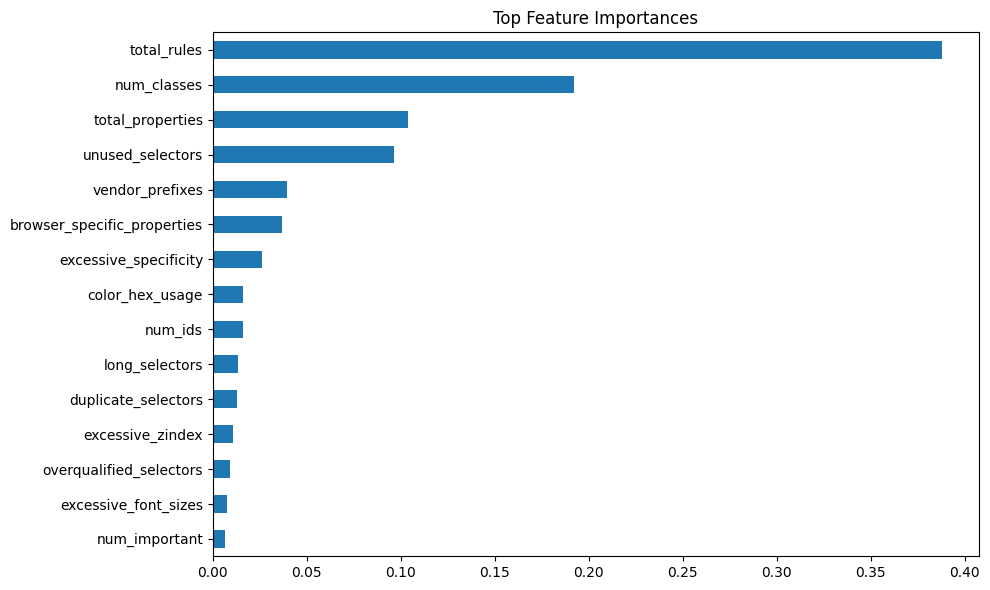

In [22]:
#Feature Importances
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.head(15).plot(kind='barh')
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
# downloading the models
joblib.dump(clf, "css_model.pkl")
joblib.dump(scaler, "css_scaler.pkl")
joblib.dump(kmeans, "css_kmeans.pkl")

from google.colab import files
files.download("css_model.pkl")
files.download("css_scaler.pkl")
files.download("css_kmeans.pkl")